# Creating Table for Busyness Prediction to give to ML Model for cleaned Subway Dataset 2019
- This notebook gets a busyness percentage for each station relative to how busy that station is in that week
- It does this using a normal distribution of the footfall traffic and difference in exit and entries
- Its final output is cleaned busyness data file


### Imports:

In [35]:
import pandas as pd
from scipy import stats
from scipy.stats import weibull_min
import numpy as np
from matplotlib import pyplot as plt

### Loading in Weather Data:


In [36]:

weather_data=pd.read_json('weatherData.json')

In [37]:
weather_data.head(10)

,lat,lon,timezone,timezone_offset,data
0,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546300800, 'sunrise': 1546258795, 'su..."
1,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546304400, 'sunrise': 1546258795, 'su..."
2,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546308000, 'sunrise': 1546258795, 'su..."
3,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546311600, 'sunrise': 1546258795, 'su..."
4,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546315200, 'sunrise': 1546258795, 'su..."
5,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546318800, 'sunrise': 1546345203, 'su..."
6,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546322400, 'sunrise': 1546345203, 'su..."
7,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546326000, 'sunrise': 1546345203, 'su..."
8,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546329600, 'sunrise': 1546345203, 'su..."
9,40.7834,-73.9663,America/New_York,-18000,"[{'dt': 1546333200, 'sunrise': 1546345203, 'su..."


- Lat: 40.7834	Lon: -73.9663

### Extract what we need from the weather data:

In [38]:
# Create an empty DataFrame to store the venue data
df_weather = pd.DataFrame(columns=['Time Stamp','Temperature (C)', 'Weather Main', 'Rain 1h', 'Snow 1h'])

#select the first venue
for k in range(len(weather_data)):
    data=weather_data.loc[k]
    time_stamp=data['data'][0]['dt']
    temp=data['data'][0]['feels_like']-273.15#store in celsius
    weather_main=data['data'][0]['weather'][0]['main']
    try:
        rain_1h=data['data'][0]['rain']['1h']
    except KeyError:
        rain_1h='NA'
    
    try:
        snow_1h=data['data'][0]['snow']['1h']
    except KeyError:
        snow_1h='NA'

    #append the values information to the DataFrame
    df_weather.loc[k] = [time_stamp,temp,weather_main,rain_1h,snow_1h]


df_weather.head(20)


,Time Stamp,Temperature (C),Weather Main,Rain 1h,Snow 1h
0,1546300800,3.86,Rain,3.06,NA
1,1546304400,2.81,Rain,4.31,NA
2,1546308000,3.41,Rain,4.38,NA
3,1546311600,3.60,Rain,5.84,NA
4,1546315200,5.45,Rain,3.77,NA
5,1546318800,5.29,Rain,3.53,NA
6,1546322400,6.00,Rain,1.07,NA
7,1546326000,6.82,Mist,0.47,NA
8,1546329600,10.08,Mist,NA,NA
9,1546333200,10.38,Mist,0.25,NA


In [39]:
#set all NA values to 0
df_weather=df_weather.replace('NA',0)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8761 entries, 0 to 8760
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time Stamp       8761 non-null   int64  
 1   Temperature (C)  8761 non-null   float64
 2   Weather Main     8761 non-null   object 
 3   Rain 1h          8761 non-null   float64
 4   Snow 1h          8761 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 410.7+ KB


In [40]:
#convert all float values to only 2 decimal places
df_weather['Temperature (C)']=df_weather['Temperature (C)'].round(2)
df_weather['Rain 1h']=df_weather['Rain 1h'].round(2)
df_weather['Snow 1h']=df_weather['Snow 1h'].round(2)

In [41]:
#save this to a file called cleanedWeatherData_2019.csv
df_weather.to_csv('cleanedWeatherData_2019.csv',index=False)

In [42]:
#group every 4 hours weather into an average of the 4 hours
df_four_hours = df_weather.copy()

for i in range(0, len(df_weather)):
    if i % 4 == 0 and i != 0:
        #this gives us every 4 hours of data from original dataset for all of 2019
        #insted get the mean of the temperature, rain and snow values
        #position at the most recent row in df_four_hours
        temp= df_weather.iloc[i-4:i]['Temperature (C)'].mean()
        rain = df_weather.iloc[i-4:i]['Rain 1h'].mean()
        snow = df_weather.iloc[i-4:i]['Snow 1h'].mean()
        #manually change the values of temp, rain and snow
        df_four_hours.iloc[i-4:i,1] = temp
        df_four_hours.iloc[i-4:i,4] = rain
        df_four_hours.iloc[i-4:i,5] = snow
    if i==0:
        df_four_hours[i] = df_weather.iloc[i]

#now keep every 4th row starting at 0
df_four_hours = df_four_hours.iloc[::4, :]
df_four_hours.head(20)


,Time Stamp,Temperature (C),Weather Main,Rain 1h,Snow 1h,0
0,1546300800,3.4200,Rain,3.06,4.3975,0.0
4,1546315200,5.8900,Rain,3.77,2.2100,0.0
8,1546329600,11.1750,Mist,0.00,0.1250,0.0
12,1546344000,13.5525,Rain,0.25,0.0625,0.0
16,1546358400,11.6800,Rain,0.50,0.2500,0.0
20,1546372800,3.6975,Clouds,0.00,0.0500,0.0
24,1546387200,2.0475,Clouds,0.00,0.0000,0.0
28,1546401600,-0.0575,Clouds,0.00,0.0000,0.0
32,1546416000,-2.0800,Clear,0.00,0.0000,0.0
36,1546430400,-1.8850,Clear,0.00,0.0000,0.0


In [43]:
#drop the last column
df_four_hours.drop(df_four_hours.columns[len(df_four_hours.columns)-1], axis=1, inplace=True)
df_four_hours.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 0 to 8760
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time Stamp       2191 non-null   int64  
 1   Temperature (C)  2191 non-null   float64
 2   Weather Main     2191 non-null   object 
 3   Rain 1h          2191 non-null   float64
 4   Snow 1h          2191 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 102.7+ KB


In [44]:
#reset the index
df_four_hours.reset_index(drop=True, inplace=True)
#keep temperature, rain and snow to 2 decimal places
df_four_hours['Temperature (C)'] = df_four_hours['Temperature (C)'].round(2)
df_four_hours['Rain 1h'] = df_four_hours['Rain 1h'].round(2)
df_four_hours['Snow 1h'] = df_four_hours['Snow 1h'].round(2)
df_four_hours.head(10)

,Time Stamp,Temperature (C),Weather Main,Rain 1h,Snow 1h
0,1546300800,3.42,Rain,3.06,4.40
1,1546315200,5.89,Rain,3.77,2.21
2,1546329600,11.18,Mist,0.00,0.12
3,1546344000,13.55,Rain,0.25,0.06
4,1546358400,11.68,Rain,0.50,0.25
5,1546372800,3.70,Clouds,0.00,0.05
6,1546387200,2.05,Clouds,0.00,0.00
7,1546401600,-0.06,Clouds,0.00,0.00
8,1546416000,-2.08,Clear,0.00,0.00
9,1546430400,-1.89,Clear,0.00,0.00


In [45]:
#drop time after 1577476800
df_four_hours.drop(df_four_hours[df_four_hours['Time Stamp'] > 1577476800].index, inplace = True)

In [46]:
#save 4 hour data to csv
df_four_hours.to_csv('cleanedWeatherData_2019_4hour.csv',index=False)

### Loading in Subway Data:


In [47]:
turnstile_data=pd.read_csv('cleaned_turnstile_data.csv')
    

In [48]:
turnstile_data.head()

,turnstile_id,remote_unit_id,time_stamp,station_name,entries,exits
0,R138 R293 00-02-03,293,1546304400,34 ST-PENN STA,139,53
1,R138 R293 00-03-02,293,1546304400,34 ST-PENN STA,100,258
2,R138 R293 00-06-00,293,1546304400,34 ST-PENN STA,222,166
3,R138 R293 00-02-05,293,1546304400,34 ST-PENN STA,101,99
4,R138 R293 00-00-04,293,1546304400,34 ST-PENN STA,227,107


### Creating busyness percentage for each station
- For each remote unit id and time condense to one row relating to busyness of that station at that time
- The busyness of a place is how many people are currently there, so exits-entries along with the magnitude in the sum of both values, can do both
- Sum of entries and exits for each remote unit id at that time
- Exits - entries for each remote unit id at that time
- Normalize each of these values

In [49]:
grouped_turnstile_data=turnstile_data.groupby(['remote_unit_id', 'time_stamp']).agg({'entries': 'max', 'exits': 'max'}).reset_index()

grouped_turnstile_data.head()

,remote_unit_id,time_stamp,entries,exits
0,1,1546315200,102,104
1,1,1546329600,96,51
2,1,1546344000,260,476
3,1,1546358400,540,496
4,1,1546372800,602,250


In [50]:
len(grouped_turnstile_data)

287475

In [51]:
#drop rows before time of 1546300800
grouped_turnstile_data.drop(grouped_turnstile_data[grouped_turnstile_data['time_stamp'] < 1546300800].index, inplace = True)

In [52]:
grouped_turnstile_data['sum_exit_entry']=grouped_turnstile_data['exits']+grouped_turnstile_data['entries']

grouped_turnstile_data.head(10)


,remote_unit_id,time_stamp,entries,exits,sum_exit_entry
0,1,1546315200,102,104,206
1,1,1546329600,96,51,147
2,1,1546344000,260,476,736
3,1,1546358400,540,496,1036
4,1,1546372800,602,250,852
5,1,1546387200,159,147,306
6,1,1546401600,48,38,86
7,1,1546416000,516,434,950
8,1,1546430400,842,1351,2193
9,1,1546444800,784,456,1240


In [53]:
#add a week number column to group further
#how many seconds in a week?
week=604800
start=1546300800
for i in range(0,52):
    current_time=start+week*i
    #for all the timestamps in the week set week number column to i
    mask = (grouped_turnstile_data['time_stamp'] >= current_time) & (grouped_turnstile_data['time_stamp'] < current_time + week)
    grouped_turnstile_data.loc[mask, 'week_num'] = i+1
#change week num to int
grouped_turnstile_data['week_num']=grouped_turnstile_data['week_num'].astype(int)


grouped_turnstile_data.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,week_num
0,1,1546315200,102,104,206,1
1,1,1546329600,96,51,147,1
2,1,1546344000,260,476,736,1
3,1,1546358400,540,496,1036,1
4,1,1546372800,602,250,852,1
5,1,1546387200,159,147,306,1
6,1,1546401600,48,38,86,1
7,1,1546416000,516,434,950,1
8,1,1546430400,842,1351,2193,1
9,1,1546444800,784,456,1240,1


In [54]:
#change week num to int
grouped_turnstile_data['week_num']=grouped_turnstile_data['week_num'].astype(int)


grouped_turnstile_data.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,week_num
0,1,1546315200,102,104,206,1
1,1,1546329600,96,51,147,1
2,1,1546344000,260,476,736,1
3,1,1546358400,540,496,1036,1
4,1,1546372800,602,250,852,1
5,1,1546387200,159,147,306,1
6,1,1546401600,48,38,86,1
7,1,1546416000,516,434,950,1
8,1,1546430400,842,1351,2193,1
9,1,1546444800,784,456,1240,1


In [55]:
grouped_turnstile_data.tail()

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,week_num
287470,572,1577419200,29,80,109,52
287471,572,1577433600,237,212,449,52
287472,572,1577448000,631,438,1069,52
287473,572,1577462400,551,500,1051,52
287474,572,1577476800,586,612,1198,52


In [56]:
#check for 0 values in sum_exit_entry
grouped_turnstile_data[grouped_turnstile_data['sum_exit_entry'] == 0]
#drop these rows
grouped_turnstile_data.drop(grouped_turnstile_data[grouped_turnstile_data['sum_exit_entry'] == 0].index, inplace = True)

In [57]:
#chck for null values
grouped_turnstile_data.isnull().sum()

remote_unit_id    0
time_stamp        0
entries           0
exits             0
sum_exit_entry    0
week_num          0
dtype: int64

### Check if data is normally distributed:
- Normality checks
- QQ plot
- Statistical measures- kurtosis and skewness


In [58]:
#choose 2 stations to see if the data is normally distributed
#station 1
station_1=grouped_turnstile_data[grouped_turnstile_data['remote_unit_id']==170]
data=station_1['sum_exit_entry']
len(data)

2138

In [59]:


shapiro_stat, shapiro_p_value = stats.shapiro(data)
print(f"Shapiro-Wilk Test - Statistic: {shapiro_stat}, p-value: {shapiro_p_value}")

Shapiro-Wilk Test - Statistic: 0.953808605670929, p-value: 1.8245112747026609e-25


In [60]:
#print the largest 50 values in data
print(data.nlargest(50))

151340    5455
151401    5272
151129    5241
151353    5209
149595    5148
151123    5115
151377    5114
151317    5088
151141    5075
151389    5075
151395    5052
151045    5037
151305    5037
151359    5033
151341    5032
151257    5017
151311    5014
151135    4986
149686    4980
150304    4977
151347    4971
151251    4961
150082    4949
149976    4940
151225    4940
151207    4939
149558    4935
149934    4928
149854    4923
151299    4921
149589    4915
150376    4911
151219    4908
149601    4904
151177    4898
151383    4879
149808    4877
149454    4849
149546    4847
151081    4847
150358    4846
149680    4843
150173    4843
150310    4830
150089    4819
151051    4811
150139    4809
150132    4806
149369    4803
149415    4803
Name: sum_exit_entry, dtype: int64


- Not normally distributed

((array([-3.41055756, -3.16075052, -3.02226281, ...,  3.02226281,
          3.16075052,  3.41055756]),
  array([  10,   10,   11, ..., 5241, 5272, 5455])),
 (1328.5342615999232, 2024.5673526660428, 0.9770551100428354))

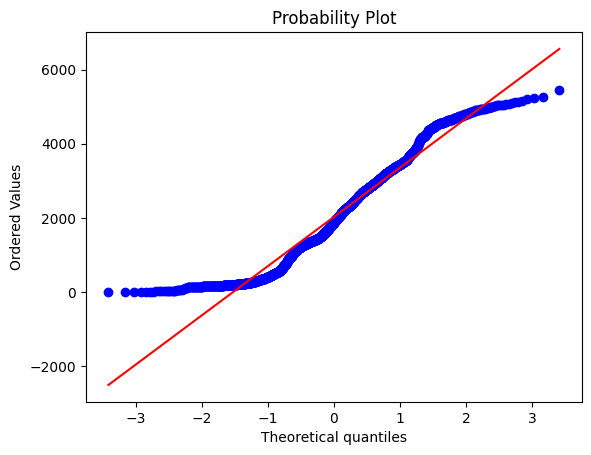

In [61]:
# qq plot for station 1
stats.probplot(data, dist="norm", plot=plt)

((array([-3.41055756, -3.16075052, -3.02226281, ...,  3.02226281,
          3.16075052,  3.41055756]),
  array([2.30258509, 2.30258509, 2.39789527, ..., 8.5642676 , 8.57016508,
         8.6042879 ])),
 (0.9939264576505292, 7.2360875544668755, 0.9370050769681953))

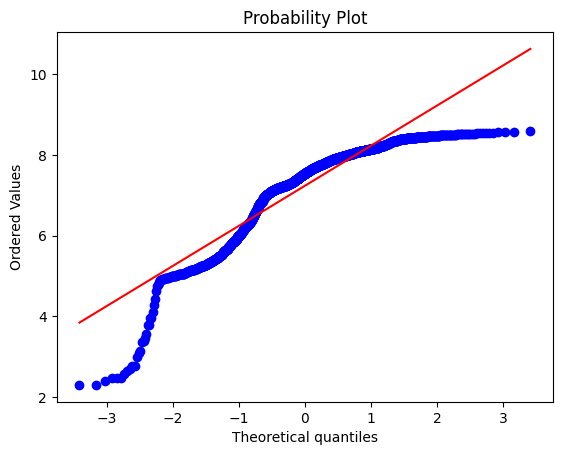

In [62]:
                          
log_data =np.log(data)

# Perform a QQ plot to check if the transformed data follows a normal distribution
stats.probplot(log_data, dist="norm", plot=plt)

((array([3.24203546e-04, 7.87125798e-04, 1.25525060e-03, ...,
         6.68104760e+00, 7.14751601e+00, 8.03430111e+00]),
  array([  10,   10,   11, ..., 5241, 5272, 5455])),
 (1259.793261406925, 765.7676225198752, 0.9238020951367082))

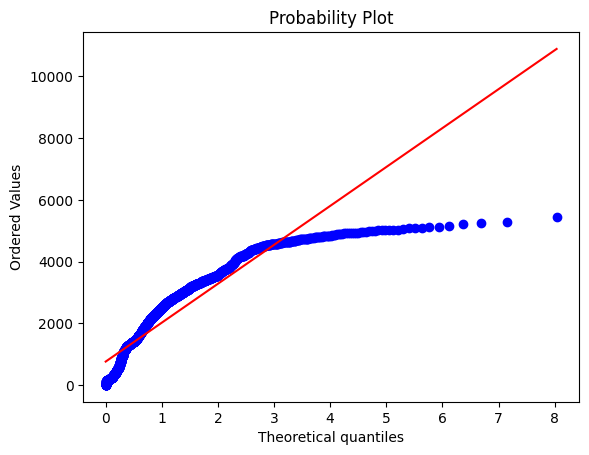

In [63]:
stats.probplot(data, dist='expon', plot=plt)



## Use weibull min with c=3 for making the z scores

((array([0.06869723, 0.09233111, 0.10787235, ..., 1.88342438, 1.9262754 ,
         2.00285435]),
  array([  10,   10,   11, ..., 5241, 5272, 5455])),
 (4130.724087262373, -1663.9159962077624, 0.986403971816686))

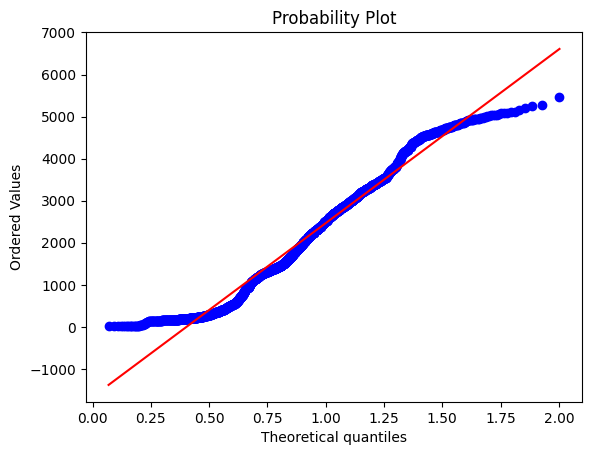

In [64]:
#weibull
stats.probplot(data, dist="weibull_min", plot=plt, sparams=(3,))

### Use of z-score
- A z-score quantifies the distance between a data point and the mean of a distribution in terms of standard deviations. It indicates how many standard deviations an observation is above or below the mean of a distribution. 

In [65]:
#first get a new dataframe for each remote_unit_id
for i in range(0, len(grouped_turnstile_data['remote_unit_id'].unique())):
    #get the remote_unit_id
    remote_unit_id=grouped_turnstile_data['remote_unit_id'].unique()[i]
    #give the new dataframe the name of the remote unit id
    df=grouped_turnstile_data[grouped_turnstile_data['remote_unit_id']==remote_unit_id]
    #reset the index
    df.reset_index(drop=True, inplace=True)
    #write it to the folder
    df.to_csv('turnstile_data/df_'+str(remote_unit_id)+'.csv',index=False)


In [79]:
#get a standardized z score for each remote unit id based on the busyness of that week number
from sklearn.preprocessing import StandardScaler

#function to be applied to each group

def standardize_group(group):
    scaler = StandardScaler()
    group[['z_score_sum_exit_entry']] = scaler.fit_transform(group[['sum_exit_entry']])
    return group

standardized_turnstile_data=pd.DataFrame()
#apply the function to each group in each turnstile_data remote unit id file
for i in range(0, len(grouped_turnstile_data['remote_unit_id'].unique())):
    #get the remote_unit_id
    remote_unit_id=grouped_turnstile_data['remote_unit_id'].unique()[i]
    #read in the file
    df=pd.read_csv('turnstile_data/df_'+str(remote_unit_id)+'.csv')
    #apply the function
    df = df.groupby('week_num', group_keys=True).apply(standardize_group)
    #write it to the folder
    df.to_csv('turnstile_data/df_'+str(remote_unit_id)+'.csv',index=False)
    #append to the standardized_turnstile_data
    standardized_turnstile_data=standardized_turnstile_data.append(df, ignore_index=True)
    
standardized_turnstile_data.head(10)

/tmp/ipykernel_5201/4049597498.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  standardized_turnstile_data=standardized_turnstile_data.append(df, ignore_index=True)
/tmp/ipykernel_5201/4049597498.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  standardized_turnstile_data=standardized_turnstile_data.append(df, ignore_index=True)
/tmp/ipykernel_5201/4049597498.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  standardized_turnstile_data=standardized_turnstile_data.append(df, ignore_index=True)
/tmp/ipykernel_5201/4049597498.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  standardized_turnstile_data=standardized_turnstile

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,week_num,z_score_sum_exit_entry
0,1,1546315200,102,104,206,1,-0.944625
1,1,1546329600,96,51,147,1,-1.024485
2,1,1546344000,260,476,736,1,-0.227234
3,1,1546358400,540,496,1036,1,0.178836
4,1,1546372800,602,250,852,1,-0.070220
5,1,1546387200,159,147,306,1,-0.809268
6,1,1546401600,48,38,86,1,-1.107053
7,1,1546416000,516,434,950,1,0.062429
8,1,1546430400,842,1351,2193,1,1.744913
9,1,1546444800,784,456,1240,1,0.454964


### Use the Weibull Distribution to map the z-score to percentage

In [80]:
grouped_turnstile_data=standardized_turnstile_data.copy()
grouped_turnstile_data['percentage_sum_exit_entry'] = weibull_min.cdf(grouped_turnstile_data['z_score_sum_exit_entry'], 3) * 100


In [81]:

grouped_turnstile_data.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,week_num,z_score_sum_exit_entry,percentage_sum_exit_entry
0,1,1546315200,102,104,206,1,-0.944625,0.000000
1,1,1546329600,96,51,147,1,-1.024485,0.000000
2,1,1546344000,260,476,736,1,-0.227234,0.000000
3,1,1546358400,540,496,1036,1,0.178836,0.570325
4,1,1546372800,602,250,852,1,-0.070220,0.000000
5,1,1546387200,159,147,306,1,-0.809268,0.000000
6,1,1546401600,48,38,86,1,-1.107053,0.000000
7,1,1546416000,516,434,950,1,0.062429,0.024328
8,1,1546430400,842,1351,2193,1,1.744913,99.507175
9,1,1546444800,784,456,1240,1,0.454964,8.987536


In [83]:
#round each percentage to the nearest multiple of 10
grouped_turnstile_data['percentage_sum_exit_entry']=grouped_turnstile_data['percentage_sum_exit_entry'].round(-1)
grouped_turnstile_data.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,week_num,z_score_sum_exit_entry,percentage_sum_exit_entry
0,1,1546315200,102,104,206,1,-0.944625,0.0
1,1,1546329600,96,51,147,1,-1.024485,0.0
2,1,1546344000,260,476,736,1,-0.227234,0.0
3,1,1546358400,540,496,1036,1,0.178836,0.0
4,1,1546372800,602,250,852,1,-0.070220,0.0
5,1,1546387200,159,147,306,1,-0.809268,0.0
6,1,1546401600,48,38,86,1,-1.107053,0.0
7,1,1546416000,516,434,950,1,0.062429,0.0
8,1,1546430400,842,1351,2193,1,1.744913,100.0
9,1,1546444800,784,456,1240,1,0.454964,10.0


In [84]:
df_busyness=grouped_turnstile_data[['remote_unit_id', 'time_stamp', 'entries', 'exits','sum_exit_entry','percentage_sum_exit_entry']].copy()
df_busyness.tail(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,percentage_sum_exit_entry
287465,572,1577347200,214,200,414,0.0
287466,572,1577361600,523,393,916,50.0
287467,572,1577376000,476,400,876,40.0
287468,572,1577390400,540,635,1175,100.0
287469,572,1577404800,119,379,498,0.0
287470,572,1577419200,29,80,109,0.0
287471,572,1577433600,237,212,449,0.0
287472,572,1577448000,631,438,1069,90.0
287473,572,1577462400,551,500,1051,90.0
287474,572,1577476800,586,612,1198,100.0


### Explain the new columns:
- Percentage_sum_exit_entry is a normalized percentage for each station (remote unit id). The higher the value the greater the total entries and exits in that time period.
- I see this as a useful metric as it is a proxy for the footfall in a station at a certain time.
- This column can be used for a more specific busyness prediciton of each station.



#### Tidy up the columns and names

In [85]:
df_busyness.rename(columns={'percentage_sum_exit_entry':'station_busyness'}, inplace=True)
df_busyness.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness
0,1,1546315200,102,104,206,0.0
1,1,1546329600,96,51,147,0.0
2,1,1546344000,260,476,736,0.0
3,1,1546358400,540,496,1036,0.0
4,1,1546372800,602,250,852,0.0
5,1,1546387200,159,147,306,0.0
6,1,1546401600,48,38,86,0.0
7,1,1546416000,516,434,950,0.0
8,1,1546430400,842,1351,2193,100.0
9,1,1546444800,784,456,1240,10.0


In [86]:
#round to the nearest percent and convert to int
df_busyness['station_busyness']=df_busyness['station_busyness'].apply(lambda x: int(x))
df_busyness.tail(20)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness
287455,572,1577203200,570,460,1030,80
287456,572,1577217600,407,532,939,60
287457,572,1577232000,144,260,404,0
287458,572,1577246400,25,101,126,0
287459,572,1577260800,64,70,134,0
287460,572,1577275200,224,157,381,0
287461,572,1577289600,315,228,543,0
287462,572,1577304000,253,321,574,0
287463,572,1577318400,115,243,358,0
287464,572,1577332800,23,70,93,0


### For training the model:
- Include the day, time of day and weather for each row, but first fix the timestamps so they align with the weather


In [87]:

#fix timestamps
#map timestamp to the nearest block of 4 hours in unix time
#this will be used to merge with the weather data

def map_to_nearest_four_hour_block(timestamp):
    base_time = 1546300800
    time_diff = timestamp - base_time
    four_hour_block = round(time_diff / (4 * 3600)) * (4 * 3600)
    mapped_timestamp = base_time+ four_hour_block
    return mapped_timestamp

df_busyness['time_stamp'] = df_busyness['time_stamp'].apply(lambda x: map_to_nearest_four_hour_block(x))


In [88]:
#add hour of the day column
df_busyness['hour']=pd.to_datetime(df_busyness['time_stamp'], unit='s').dt.hour
#add day column
df_busyness['day']=pd.to_datetime(df_busyness['time_stamp'], unit='s').dt.day_name()
#add day of the month and month, eg 1 January
df_busyness['month']=pd.to_datetime(df_busyness['time_stamp'], unit='s').dt.month_name()

df_busyness.head(10)


,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness,hour,day,month
0,1,1546315200,102,104,206,0,4,Tuesday,January
1,1,1546329600,96,51,147,0,8,Tuesday,January
2,1,1546344000,260,476,736,0,12,Tuesday,January
3,1,1546358400,540,496,1036,0,16,Tuesday,January
4,1,1546372800,602,250,852,0,20,Tuesday,January
5,1,1546387200,159,147,306,0,0,Wednesday,January
6,1,1546401600,48,38,86,0,4,Wednesday,January
7,1,1546416000,516,434,950,0,8,Wednesday,January
8,1,1546430400,842,1351,2193,100,12,Wednesday,January
9,1,1546444800,784,456,1240,10,16,Wednesday,January


In [89]:
df_busyness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287475 entries, 0 to 287474
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   remote_unit_id    287475 non-null  int64 
 1   time_stamp        287475 non-null  int64 
 2   entries           287475 non-null  int64 
 3   exits             287475 non-null  int64 
 4   sum_exit_entry    287475 non-null  int64 
 5   station_busyness  287475 non-null  int64 
 6   hour              287475 non-null  int64 
 7   day               287475 non-null  object
 8   month             287475 non-null  object
dtypes: int64(7), object(2)
memory usage: 19.7+ MB


- Missing last 4 days of Subway data in 2019 for every station

### Map the weather to each station for each time interval

In [90]:
#load in weather data
df_four=pd.read_csv('cleanedWeatherData_2019_4hour.csv')

In [91]:
df_four.head()

,Time Stamp,Temperature (C),Weather Main,Rain 1h,Snow 1h
0,1546300800,3.42,Rain,3.06,4.40
1,1546315200,5.89,Rain,3.77,2.21
2,1546329600,11.18,Mist,0.00,0.12
3,1546344000,13.55,Rain,0.25,0.06
4,1546358400,11.68,Rain,0.50,0.25


In [92]:
#create a mask that assigns each row in df_busyness to a 4 hour period
#based on timestamp value being the same
for i in range(len(df_four)):
    #every timestamp in df_weather that is equivalent to df_four[i] gets new columns added with the weather data from that timestamp in df_four
    mask = (df_busyness['time_stamp'] == df_four['Time Stamp'][i])
    df_busyness.loc[mask, 'Temperature (C)'] = df_four['Temperature (C)'][i]
    df_busyness.loc[mask, 'Weather Main'] = df_four['Weather Main'][i]
    df_busyness.loc[mask, 'Rain 1h'] = df_four['Rain 1h'][i]
    df_busyness.loc[mask, 'Snow 1h'] = df_four['Snow 1h'][i]


df_busyness.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness,hour,day,month,Temperature (C),Weather Main,Rain 1h,Snow 1h
0,1,1546315200,102,104,206,0,4,Tuesday,January,5.89,Rain,3.77,2.21
1,1,1546329600,96,51,147,0,8,Tuesday,January,11.18,Mist,0.00,0.12
2,1,1546344000,260,476,736,0,12,Tuesday,January,13.55,Rain,0.25,0.06
3,1,1546358400,540,496,1036,0,16,Tuesday,January,11.68,Rain,0.50,0.25
4,1,1546372800,602,250,852,0,20,Tuesday,January,3.70,Clouds,0.00,0.05
5,1,1546387200,159,147,306,0,0,Wednesday,January,2.05,Clouds,0.00,0.00
6,1,1546401600,48,38,86,0,4,Wednesday,January,-0.06,Clouds,0.00,0.00
7,1,1546416000,516,434,950,0,8,Wednesday,January,-2.08,Clear,0.00,0.00
8,1,1546430400,842,1351,2193,100,12,Wednesday,January,-1.89,Clear,0.00,0.00
9,1,1546444800,784,456,1240,10,16,Wednesday,January,0.04,Clear,0.00,0.00


In [93]:
#show null rows
df_busyness[df_busyness.isnull().any(axis=1)]


,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness,hour,day,month,Temperature (C),Weather Main,Rain 1h,Snow 1h
6525,11,1577491200,668,1312,1980,0,0,Saturday,December,NaN,NaN,NaN,NaN
8655,12,1577491200,683,1319,2002,40,0,Saturday,December,NaN,NaN,NaN,NaN
10705,13,1577491200,326,819,1145,10,0,Saturday,December,NaN,NaN,NaN,NaN
16855,16,1577491200,165,148,313,0,0,Saturday,December,NaN,NaN,NaN,NaN
18964,17,1577491200,463,326,789,0,0,Saturday,December,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253821,323,1577491200,215,358,573,0,0,Saturday,December,NaN,NaN,NaN,NaN
257733,330,1577491200,237,268,505,40,0,Saturday,December,NaN,NaN,NaN,NaN
269331,344,1577491200,116,20,136,0,0,Saturday,December,NaN,NaN,NaN,NaN
271195,345,1577491200,80,338,418,10,0,Saturday,December,NaN,NaN,NaN,NaN


In [94]:
#drop these rows
df_busyness.dropna(inplace=True)


### Convert Percentages to Categories
- Not Busy: 0-25% label is 1
- Moderate: 26-50% label is 2
- Busy: 51-75% label is 3
- Very Busy: 76-100% label is 4

In [95]:
#for all values in surrounding_area_busyness add a new column to that row for converting to 'Not Busy' if between 0 and 25, etc
df_busyness['station_category'] = df_busyness['station_busyness'].apply(lambda x: 1 if x <= 25 else (2 if 26 <= x <= 50 else (3 if 51 <= x <= 75 else 4)))


In [97]:
df_busyness['station_category'].value_counts()

1    207237
4     47840
2     20031
3     12291
Name: station_category, dtype: int64

In [98]:
df_busyness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287399 entries, 0 to 287474
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   remote_unit_id    287399 non-null  int64  
 1   time_stamp        287399 non-null  int64  
 2   entries           287399 non-null  int64  
 3   exits             287399 non-null  int64  
 4   sum_exit_entry    287399 non-null  int64  
 5   station_busyness  287399 non-null  int64  
 6   hour              287399 non-null  int64  
 7   day               287399 non-null  object 
 8   month             287399 non-null  object 
 9   Temperature (C)   287399 non-null  float64
 10  Weather Main      287399 non-null  object 
 11  Rain 1h           287399 non-null  float64
 12  Snow 1h           287399 non-null  float64
 13  station_category  287399 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 32.9+ MB


In [99]:
#change the column names
df_busyness.rename(columns={'Temperature (C)':'temperature', 'Weather Main': 'weather', 'Rain 1h':'rain_fall','Snow 1h': 'snow_fall'}, inplace=True)

In [100]:
#ready to train model now with this dataset
df_busyness.to_csv('cleaned_busyness_data.csv',index=False)

### Plots for data visualization:
- Subway data- plot each station by largest total entries and exits for the year
- BestTime api- show busyness of statue of liberty for the week?
- Weather data- plot rainfall for the each month?

In [ ]:
# Copy the data
subway_plot = turnstile_data.copy()

# Group by 'remote_unit_id' and calculate the total 'entries' and 'exits'

subway_plot = subway_plot.groupby('remote_unit_id')['entries', 'exits'].sum().reset_index()

# Calculate the total entries and exits and add a new column
subway_plot['total_entries_exits'] = subway_plot['entries'] + subway_plot['exits']

# Sort the DataFrame by 'total_entries_exits' in descending order
subway_plot = subway_plot.sort_values('total_entries_exits', ascending=False)

# Convert the DataFrame to a list
plot = subway_plot[['remote_unit_id', 'total_entries_exits']].values.tolist()

#look up the remote unit id in the cleaned_station_data.csv file
station_data=pd.read_csv('cleaned_station_data.csv')
#check how many unique station names there are
print(len(station_data['station_name'].unique()))
#check how many unique remote unit ids there are
print(len(station_data['remote_unit_id'].unique()))

for i in range(len(plot)):
    if plot[i][0] in station_data['remote_unit_id'].values:
        plot[i][0]=station_data[station_data['remote_unit_id']==plot[i][0]]['station_name'].values[0]

#sort in descending order
plot.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 stations
#print(plot[0:10])


/tmp/ipykernel_25507/4026529364.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subway_plot = subway_plot.groupby('remote_unit_id')['entries', 'exits'].sum().reset_index()


86
143


/tmp/ipykernel_25507/4026529364.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if plot[i][0] in station_data['remote_unit_id'].values:


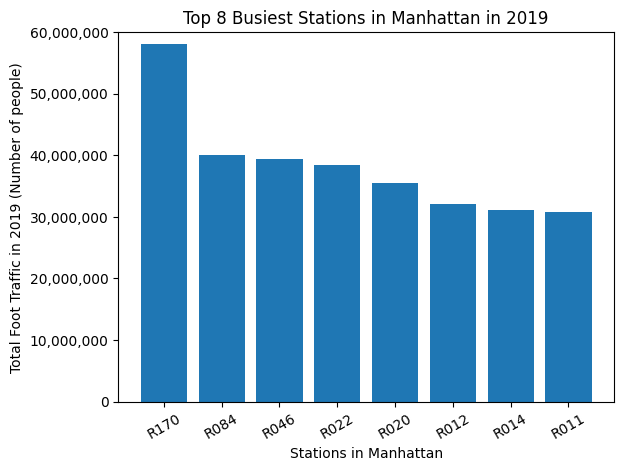

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

remote_id = [entry[0] for entry in plot[:8]]  # Get the top 10 stations
total_volume = [entry[1] for entry in plot[:8]]  # Get the total volume for each station

# Define the desired range for the y-axis
y_min = 0
y_max = 60000000

plt.bar(remote_id, total_volume)
plt.xlabel('Stations in Manhattan')
plt.ylabel('Total Foot Traffic in 2019 (Number of people)')
plt.title('Top 8 Busiest Stations in Manhattan in 2019')

# Format the y-axis labels with commas and set the range
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(y_min, y_max)

plt.xticks(rotation=30)
plt.show()


In [ ]:
# add the total volume to get total foot traffic value
tot = sum(entry[1] for entry in plot)
tot

1642167565